# Description of this notebook
* This notebook contains all the codes used to clean, preprocesse, perform initial EDA, engineer features, and produce the final merged dataset used for model building
* Model building is contain in the next jupyter notebook: Bar_Crawl_finaldataEDA_modelTraining
* Each section is labeled with headings

# Background Information from the e-mail

## Problem:
You are given cell phone accelerometer data on 13 participants before and after they go drinking and their
blood alcohol content via transdermal alcohol concentration (TAC).

## Goal:
- **Given a 10 second window of non-zero accelerometer data, predict whether the TAC is above 0.08 (intoxicated).**
- This is formulated as a classification problem, but you are free to use any techniques or methods that you would like. I recommend starting off simply just to get some baseline models.
- Please report your accuracy and F1 scores.

## Data:
- [This link contains the data for download ](https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking)
- Use the cleaned data (clean_tac)

## Format:
- This test is mostly about your data science problem-solving ability, but the focus is also on the software engineering aspect. A successful submission will be as follows:

    1. Either a GitHub repository or a zipped up directory of the project sent via email
    2. README explaining the needed steps to run the code, and some explanation of your solution
    3. Will use Python 3
    4. If any data exploration, keep the code/plots even if it is messy
    5. Due date is one week from this email -- please let us know early if you need additional accommodations and why.
    
## Information from UCI (the data source)
- 13 participants TAC info
- Accelerometer data was collected from smartphones at a sampling rate of 40Hz (file: all_accelerometer_data_pids_13.csv).
    - The file contains 5 columns: a timestamp, a participant ID, and a sample from each axis of the accelerometer. Data was collected from a mix of 11 iPhones and 2 Android phones as noted in phone_types.csv. TAC data was collected using SCRAM [2] ankle bracelets and was collected at 30 minute intervals.
- The raw TAC readings are in the raw_tac directory.
- TAC readings which are more readily usable for processing are in clean_tac directory
    - have two columns: a timestamp and TAC reading. The cleaned TAC readings: (1) were processed with a zero-phase low-pass filter to smooth noise without shifting phase; (2) were shifted backwards by 45 minutes so the labels more closely match the true intoxication of the participant (since alcohol takes about 45 minutes to exit through the skin.)

# Files

## files needed:
* accelerameter data
* clean-tac data

* phone_types data

## files probably not needed:
* pids probably not needed
* would not need the raw_tac

# Goal
* we want to look at a 10 seconds window of acc. data to predict whether someone is intoxicated (binary class)
    * TAC 0.08 is the legal limit for driving - above which is considered intoxicated

# Intuition of using the acc. data
* intoxicated people are more likely to do random movement
* potentially faster acc?
* or simply more movement

# Apporach to building the model

1. Check for missing data (don't expect any) and then link the accelerometer data from the 13 participants to their TAC readings (merge data)
2. Do EDA - looking at correlation, distribution, etc
3. feature engineering
    * 10 second window data of acc data
4. Pre-process data for modeling - train/test split
5. Build a model
    * Looks like a basic binary classificaiton problem -> TAC above 0.08 or TAC below 0.08
    * basically want to predict: intoxicated / not-intoxicated
    * I would try a basic logistic regression model first
5. Try different models / evaluate
6. Summarize

# Importing acc data

In [1]:
import pandas as pd

In [2]:
acc_link = '../bar_brawl_data/all_accelerometer_data_pids_13.csv'
acc = pd.read_csv(acc_link)

In [3]:
acc.head(20)

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163
5,1493733883945,SA0297,-0.2888,0.0514,-0.0145
6,1493733883953,SA0297,-0.0413,-0.0184,-0.0105
7,1493733883957,SA0297,-0.0413,-0.0001,0.0017
8,1493733883963,SA0297,-0.0286,-0.0028,-0.0094
9,1493733883974,SA0297,-0.0543,-0.0410,-0.0109


all_accelerometer_data_pids_13.csv:
- time: integer, unix timestamp, **milliseconds**
- pid: symbolic, 13 categories listed in pids.txt
- x: continuous, time-series
- y: continuous, time-series
- z: continuous, time-series

Notes:
* want at 10 second window
    * need to do that calc based on the PID -- for each of 13 participants
* For the x, y, z
    * Positive values indicate an increase in velocity.
    * Negative values indicate an decrease in velocity.
    * Zero values indicate constant velocity (which might not be zero).

In [4]:
# looks roughly fine - looks like y and z can vary ALOT? x is not really changing? Could be depending on the person?
acc.describe()

,time,x,y,z
count,1.405757e+07,1.405757e+07,1.405757e+07,1.405757e+07
mean,1.493778e+12,-9.269848e-03,-7.168398e+06,7.168398e+06
std,5.640453e+08,9.540696e-01,3.528998e+07,3.528998e+07
min,0.000000e+00,-4.333507e+01,-1.809008e+08,-4.902300e+01
25%,1.493755e+12,-5.700000e-03,-4.500000e-03,-4.200000e-03
50%,1.493779e+12,-2.000000e-04,-2.000000e-04,6.100000e-03
75%,1.493801e+12,7.600000e-03,4.500000e-03,4.605889e-02
max,1.493829e+12,3.922540e+01,2.731123e+01,1.809008e+08


In [5]:
# no null data - good
acc.isnull().sum()

time    0
pid     0
x       0
y       0
z       0
dtype: int64

In [6]:
# want to convert time from unix timestamp to real time
acc['time'] = pd.to_datetime(acc['time'],unit='ms')

In [7]:
acc.head(20)

,time,pid,x,y,z
0,1970-01-01 00:00:00.000,JB3156,0.0000,0.0000,0.0000
1,1970-01-01 00:00:00.000,CC6740,0.0000,0.0000,0.0000
2,2017-05-02 14:04:42.409,SA0297,0.0758,0.0273,-0.0102
3,2017-05-02 14:04:42.455,SA0297,-0.0359,0.0794,0.0037
4,2017-05-02 14:04:42.500,SA0297,-0.2427,-0.0861,-0.0163
5,2017-05-02 14:04:43.945,SA0297,-0.2888,0.0514,-0.0145
6,2017-05-02 14:04:43.953,SA0297,-0.0413,-0.0184,-0.0105
7,2017-05-02 14:04:43.957,SA0297,-0.0413,-0.0001,0.0017
8,2017-05-02 14:04:43.963,SA0297,-0.0286,-0.0028,-0.0094
9,2017-05-02 14:04:43.974,SA0297,-0.0543,-0.0410,-0.0109


In [8]:
# the first 2 entry must just be the baseline 0, can dropthem
acc = acc.drop([0,1])

In [9]:
acc.groupby('pid').count()

# each participant have different numbers of entries

,time,x,y,z
pid,,,,
BK7610,1225727,1225727,1225727,1225727
BU4707,447423,447423,447423,447423
CC6740,2374694,2374694,2374694,2374694
DC6359,591358,591358,591358,591358
DK3500,1339622,1339622,1339622,1339622
HV0618,1876013,1876013,1876013,1876013
JB3156,1177748,1177748,1177748,1177748
JR8022,307526,307526,307526,307526
MC7070,318600,318600,318600,318600


# importing TAC data

* TAC data was collected using SCRAM ankle bracelets and was collected at 30 minute intervals.
* clean_tac/*.csv:
    * timestamp: integer, unix timestamp, **seconds**
    * TAC_Reading: continuous, time-series

In [10]:
clean_tac_folder_link = './data/clean_tac/'

In [11]:
# there are 13 files in the clean_tac folder, let's get their names
# using linux command line ls to get the file names in 1 col
!ls data/clean_tac -1

BK7610_clean_TAC.csv
BU4707_clean_TAC.csv
CC6740_clean_TAC.csv
DC6359_clean_TAC.csv
DK3500_clean_TAC.csv
HV0618_clean_TAC.csv
JB3156_clean_TAC.csv
JR8022_clean_TAC.csv
MC7070_clean_TAC.csv
MJ8002_clean_TAC.csv
PC6771_clean_TAC.csv
SA0297_clean_TAC.csv
SF3079_clean_TAC.csv


In [12]:
#all the names of the files
clean_tac_files = [
'BK7610_clean_TAC.csv',
'BU4707_clean_TAC.csv',
'CC6740_clean_TAC.csv',
'DC6359_clean_TAC.csv',
'DK3500_clean_TAC.csv',
'HV0618_clean_TAC.csv',
'JB3156_clean_TAC.csv',
'JR8022_clean_TAC.csv',
'MC7070_clean_TAC.csv',
'MJ8002_clean_TAC.csv',
'PC6771_clean_TAC.csv',
'SA0297_clean_TAC.csv',
'SF3079_clean_TAC.csv'
]

In [13]:
def combine_db_from_folder(folder_link,files_list):
    """
    Take in the filepath to a folder containing csv files and a list containing the csv names,
    read in the csv as dataframes
    and return a combined dataframes with a column specifying where the file comes from
    
    input:
    folder_link : the filepath of the folder containing the csv files
    files_list : a list containing the name of the files inside the folder-file name follow format "BK7610_clean_TAC.csv"
    
    output:
    combined = a pandas dataframe contanining all the entries from the different files
    """
    combined = pd.DataFrame()
    for file in files_list:
        ind_db = pd.read_csv(folder_link+file)
        ind_db['participant'] = file.split('_')[0] # want to only get the participant code, the first part of filename
        combined = pd.concat([ind_db,combined])
    return combined

In [14]:
# test reading one
ind_db = pd.read_csv(clean_tac_folder_link+clean_tac_files[0])

In [15]:
ind_db.shape

(57, 2)

In [16]:
ind_db.head()

,timestamp,TAC_Reading
0,1493718714,-0.000482
1,1493720697,0.001573
2,1493721027,0.002144
3,1493721357,0.000877
4,1493721686,-0.001145


In [17]:
# using the function to get the combined database from all the csv files
tacs = combine_db_from_folder(clean_tac_folder_link,clean_tac_files)

In [18]:
tacs.shape

(715, 3)

In [19]:
tacs.head()

,timestamp,TAC_Reading,participant
0,1493722490,-0.008826,SF3079
1,1493724435,-0.014854,SF3079
2,1493724750,-0.012176,SF3079
3,1493725064,0.000510,SF3079
4,1493725378,0.015509,SF3079


In [20]:
# want to convert time from unix timestamp to real time - unit is seconds - should be every 30min a reading
tacs['timestamp'] = pd.to_datetime(tacs['timestamp'],unit='s')

In [21]:
# let's make a col to mark above 0.08 as intoxicated
import numpy as np
tacs['intoxicated'] = np.where(tacs['TAC_Reading']>=0.08,1,0)

In [22]:
tacs.tail()

,timestamp,TAC_Reading,participant,intoxicated
52,2017-05-03 08:33:07,0.000429,BK7610,0
53,2017-05-03 09:07:18,0.001055,BK7610,0
54,2017-05-03 09:37:33,0.000804,BK7610,0
55,2017-05-03 10:08:04,-0.000574,BK7610,0
56,2017-05-03 10:38:19,-0.002732,BK7610,0


# Processing and combing data from acc measurement and TACS

## EDA on ACC data

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
acc.head()
# want to make 10 second window of NON-ZERO accelerator data

,time,pid,x,y,z
2,2017-05-02 14:04:42.409,SA0297,0.0758,0.0273,-0.0102
3,2017-05-02 14:04:42.455,SA0297,-0.0359,0.0794,0.0037
4,2017-05-02 14:04:42.500,SA0297,-0.2427,-0.0861,-0.0163
5,2017-05-02 14:04:43.945,SA0297,-0.2888,0.0514,-0.0145
6,2017-05-02 14:04:43.953,SA0297,-0.0413,-0.0184,-0.0105


In [25]:
acc_timeidx = acc.set_index('time')
# setting the time as the index so we can resmaple every 10 seconds

In [26]:
acc_timeidx.describe()

,x,y,z
count,1.405756e+07,1.405756e+07,1.405756e+07
mean,-9.269850e-03,-7.168399e+06,7.168399e+06
std,9.540697e-01,3.528998e+07,3.528998e+07
min,-4.333507e+01,-1.809008e+08,-4.902300e+01
25%,-5.700000e-03,-4.500000e-03,-4.200000e-03
50%,-2.000000e-04,-2.000000e-04,6.100000e-03
75%,7.600000e-03,4.500000e-03,4.605913e-02
max,3.922540e+01,2.731123e+01,1.809008e+08


In [27]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
acc_timeidx.groupby('pid').describe()

x                                                              \
            count      mean       std       min       25%       50%       75%   
pid                                                                             
BK7610  1225727.0 -0.006498  0.138047  -4.27480 -0.009400  0.000100  0.008300   
BU4707   447423.0  0.000646  0.132427  -6.95770 -0.017600 -0.001000  0.017100   
CC6740  2374694.0  0.020149  0.914247 -34.26409 -0.020471  0.007260  0.037930   
DC6359   591358.0  0.042825  0.234329  -6.35110 -0.003500  0.000700  0.010000   
DK3500  1339622.0 -0.005707  0.111117  -3.26670 -0.000700 -0.000200  0.000200   
HV0618  1876013.0  0.000120  0.060947  -4.45290 -0.003000 -0.001800  0.000700   
JB3156  1177748.0 -0.151834  3.002245 -43.33507 -0.453403  0.031338  1.193576   
JR8022   307526.0 -0.016132  0.221884  -7.51580 -0.010400 -0.000100  0.008900   
MC7070   318600.0  0.000631  0.096285  -5.40330 -0.004600 -0.000300  0.002400   
MJ8002   631303.0  0.000472  0.136622  -6.89120 -0.004300  0.000100  0.004500   
PC6771  2141701.0 -0.001091  0.086250  -4.13820 -0.006500  0.000100  0.004100   
SA0297   962901.0 -0.002821  0.109689  -5.75930 -0.001500 -0.000100  0.001600   
SF3079   662949.0 -0.000077  0.184856  -4.52900 -0.016000 -0.000900  0.014100   

                           y                                            \
              max      count          mean           std           min   
pid                                                                      
BK7610   6.450300  1225727.0  7.507374e-03  1.387602e-01 -6.948900e+00   
BU4707   6.298100   447423.0 -7.077012e-04  1.057549e-01 -3.413500e+00   
CC6740  27.440683  2374694.0  4.185654e-02  9.849421e-01 -3.099545e+01   
DC6359   5.658100   591358.0  4.120432e-02  2.824186e-01 -4.338000e+00   
DK3500   3.584000  1339622.0  8.260187e-03  1.362411e-01 -5.132300e+00   
HV0618   4.046400  1876013.0  1.359457e-03  7.491954e-02 -7.289400e+00   
JB3156  39.225403  1177748.0 -8.556179e+07  9.031822e+07 -1.809008e+08   
JR8022   6.181300   307526.0  1.381441e-02  2.566606e-01 -4.633500e+00   
MC7070   7.133000   318600.0  2.872189e-03  1.159326e-01 -3.793500e+00   
MJ8002   7.544300   631303.0  5.725275e-03  1.328901e-01 -5.729500e+00   
PC6771   7.022900  2141701.0  1.967535e-03  7.986714e-02 -4.177200e+00   
SA0297   4.490900   962901.0 -4.864100e-04  1.057364e-01 -7.322200e+00   
SF3079   7.070700   662949.0  7.199850e-03  1.605112e-01 -2.951000e+00   

                                                             z                \
                 25%       50%       75%        max      count          mean   
pid                                                                            
BK7610 -6.000000e-03  0.000100  0.009400   5.344100  1225727.0  2.747567e-03   
BU4707 -2.230000e-02  0.001000  0.021900   4.643600   447423.0  6.592096e-03   
CC6740 -1.719774e-02  0.011328  0.046827  27.311228  2374694.0  3.598449e-01   
DC6359 -1.090000e-02 -0.001100  0.003300   6.986400   591358.0 -1.145479e-02   
DK3500 -3.000000e-04  0.000100  0.000500   5.286900  1339622.0  1.604306e-02   
HV0618 -1.200000e-03 -0.000400  0.000400   6.375600  1876013.0  5.120897e-03   
JB3156 -1.809008e+08 -3.342143 -0.033680  21.285099  1177748.0  8.556179e+07   
JR8022 -3.500000e-03  0.000700  0.012300   8.801400   307526.0 -1.674581e-02   
MC7070 -2.600000e-03  0.000000  0.003900   7.439900   318600.0  4.278331e-03   
MJ8002 -3.800000e-03  0.000100  0.005100   8.370300   631303.0 -3.175206e-03   
PC6771 -1.700000e-03 -0.000300  0.001100   4.652900  2141701.0  2.553681e-03   
SA0297 -1.700000e-03 -0.000400  0.000900   3.443900   962901.0 -4.183876e-03   
SF3079 -1.080000e-02  0.001400  0.021300   6.930700   662949.0  7.190248e-04   

                                                                   \
                 std        min       25%       50%           75%   
pid                                                                 
BK7610  1.279124e-01  -5.277200 -0.007300  0.0

* CC6740 AND JB3156 seems to be on a different scale than the other participants -- is it because they use different device to measure the acc??

In [28]:
phonetype = pd.read_csv('../bar_brawl_data/phone_types.csv')

In [29]:
phonetype

,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone
5,HV0618,iPhone
6,JB3156,Android
7,JR8022,iPhone
8,MC7070,iPhone
9,MJ8002,iPhone


* Indeed, only those two participants are using Android, need to normalize the acc data
* Also each person has different scaling

## Normalizing based on individual participant

In [30]:
def groupby_normalize(df,groupby_col='pid'):
    """
    max-min scaling the numerical col of a df on a group-to-group basis
    """
    df_norm = df.groupby(groupby_col).transform(lambda x: (x - x.mean()) / (x.max()-x.min()))
    
    # for those that are numerical, making sure to add back to the normalized df
    non_numerical_cols = df.select_dtypes(exclude=['int','float']).columns
    for col in non_numerical_cols:
        df_norm[col] = df[col]
    return df_norm

In [31]:
acc_norm = groupby_normalize(acc_timeidx,'pid')

In [32]:
acc_norm.groupby('pid').describe()
# mean of 0, std of 1

x                                                        \
            count          mean       std       min       25%       50%   
pid                                                                       
BK7610  1225727.0 -1.605019e-19  0.012871 -0.397973 -0.000271  0.000615   
BU4707   447423.0  7.940391e-21  0.009990 -0.524928 -0.001376 -0.000124   
CC6740  2374694.0  4.750029e-20  0.014816 -0.555617 -0.000658 -0.000209   
DC6359   591358.0  3.304246e-20  0.019512 -0.532419 -0.003857 -0.003508   
DK3500  1339622.0 -4.684143e-19  0.016220 -0.476009  0.000731  0.000804   
HV0618  1876013.0  4.790792e-20  0.007171 -0.523928 -0.000367 -0.000226   
JB3156  1177748.0  8.759253e-19  0.036364 -0.523050 -0.003653  0.002219   
JR8022   307526.0  1.444070e-20  0.016199 -0.547537  0.000418  0.001170   
MC7070   318600.0 -3.484692e-21  0.007681 -0.431063 -0.000417 -0.000074   
MJ8002   631303.0 -8.496340e-21  0.009464 -0.477411 -0.000331 -0.000026   
PC6771  2141701.0  4.468468e-20  0.007728 -0.370672 -0.000485  0.000107   
SA0297   962901.0  3.228395e-20  0.010701 -0.561597  0.000129  0.000265   
SF3079   662949.0  8.641315e-20  0.015936 -0.390435 -0.001373 -0.000071   

                                    y                                    \
             75%       max      count          mean       std       min   
pid                                                                       
BK7610  0.001380  0.602027  1225727.0  1.166628e-19  0.011288 -0.565884   
BU4707  0.001241  0.475072   447423.0 -8.374631e-20  0.013126 -0.423576   
CC6740  0.000288  0.444383  2374694.0 -7.091382e-19  0.016892 -0.532311   
DC6359 -0.002733  0.467581   591358.0 -3.905018e-19  0.024939 -0.386705   
DK3500  0.000862  0.523991  1339622.0  7.047762e-19  0.013076 -0.493374   
HV0618  0.000068  0.476072  1876013.0 -4.021553e-20  0.005483 -0.533535   
JB3156  0.016296  0.476950  1177748.0  1.474963e-16  0.499269 -0.527024   
JR8022  0.001828  0.452463   307526.0  3.465769e-20  0.019104 -0.345914   
MC7070  0.000141  0.568937   318600.0  1.327668e-19  0.010320 -0.337954   
MJ8002  0.000279  0.522589   631303.0  1.749828e-19  0.009425 -0.406759   
PC6771  0.000465  0.629328  2141701.0 -1.273669e-19  0.009045 -0.473287   
SA0297  0.000431  0.438403   962901.0 -9.408465e-20  0.009821 -0.680071   
SF3079  0.001222  0.609565   662949.0  5.827863e-20  0.016243 -0.299361   

                                                        z                \
             25%       50%       75%       max      count          mean   
pid                                                                       
BK7610 -0.001099 -0.000603  0.000154  0.434116  1225727.0 -1.956457e-20   
BU4707 -0.002680  0.000212  0.002806  0.576424   447423.0 -4.367215e-20   
CC6740 -0.001013 -0.000524  0.000085  0.467689  2374694.0 -1.148983e-18   
DC6359 -0.004601 -0.003736 -0.003347  0.613295   591358.0 -3.026389e-19   
DK3500 -0.000822 -0.000783 -0.000745  0.506626  1339622.0  6.822339e-19   
HV0618 -0.000187 -0.000129 -0.000070  0.466465  1876013.0  1.987428e-19   
JB3156 -0.527023  0.472976  0.472976  0.472976  1177748.0  3.745325e-17   
JR8022 -0.001289 -0.000976 -0.000113  0.654086   307526.0  2.397157e-19   
MC7070 -0.000487 -0.000256  0.000091  0.662046   318600.0 -9.966220e-20   
MJ8002 -0.000676 -0.000399 -0.000044  0.593241   631303.0  6.858624e-21   
PC6771 -0.000415 -0.000257 -0.000098  0.526713  2141701.0  7.029284e-20   
SA0297 -0.000113  0.000008  0.000129  0.319929   962901.0 -1.591137e-19   
SF3079 -0.001822 -0.000587  0.001427  0.700639   662949.0 -1.875634e-20   

                                                                    
             std       min       25%       50%       75%       max  
pid                                                                 
BK7610  0.012877 -0.531519 -0.001011  0.000297  0.000871  0.468481  
BU4707  0.013085 -0.505164 -0.002502 -0.000020  0.001960  0.494836  
CC6740  0.013522 -0.527263 -0.003343  0.002610  0.003499  0.472737  

In [33]:
acc_SA0297 = acc_norm[acc_timeidx.pid=='SA0297']

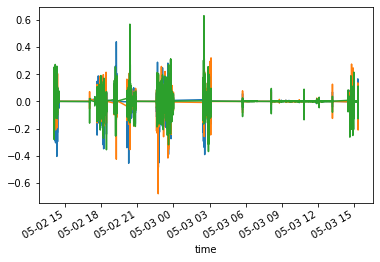

In [34]:
acc_SA0297.x.plot()
acc_SA0297.y.plot()
acc_SA0297.z.plot()

- looks like x,y,z movement are correlated with each other
- we want to predict whether someone is intoxicated for each spike of movement --- huge up and down

In [35]:
acc_norm.head()

,x,y,z,pid
time,,,,
2017-05-02 14:04:42.409,0.007670,0.002581,-0.000506,SA0297
2017-05-02 14:04:42.455,-0.003227,0.007420,0.000663,SA0297
2017-05-02 14:04:42.500,-0.023402,-0.007952,-0.001018,SA0297
2017-05-02 14:04:43.945,-0.027900,0.004819,-0.000867,SA0297
2017-05-02 14:04:43.953,-0.003754,-0.001664,-0.000531,SA0297


In [36]:
def plot_ind_graphs(df,pid_col='pid',y_col='x'):
    plt.figure(figsize=(30,20))
    n=0
    pid_index = df[pid_col].unique()
    size = len(pid_index)
    for val in pid_index:
        df2 = df[df[pid_col]==val]
        ax = plt.subplot(3,(size//3)+1,n+1)
        n+=1
        df2[y_col].plot()
        plt.xticks(rotation=45)
        plt.title(str(val))
    plt.show()

In [37]:
acc_SA0297_nonidx = acc_SA0297.reset_index()

In [38]:
acc_SA0297_nonidx[acc_SA0297_nonidx.x>1]

,time,x,y,z,pid


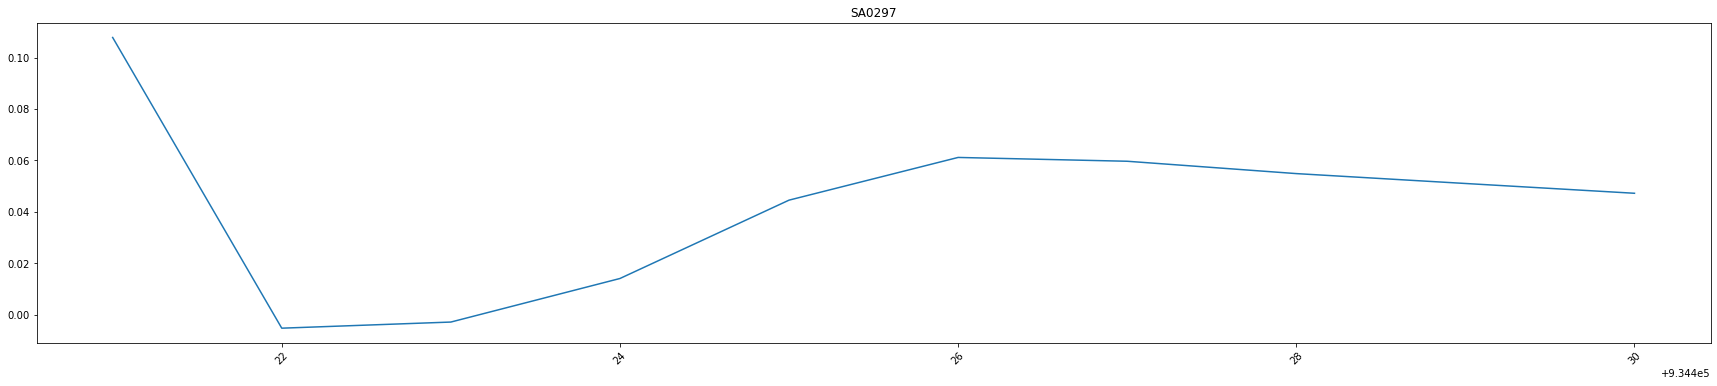

In [39]:
high_idx = acc_SA0297_nonidx[acc_SA0297_nonidx.time=='2017-05-03 14:57:22.831'].index.values[0]
end_high_idx = high_idx+10
frag = acc_SA0297_nonidx[high_idx:end_high_idx]
plot_ind_graphs(frag)

## Feature engineering for 10s acc resampling

In [40]:
# seperate by participant code so that we won't be mixing up timestamp of different participant
# downsample every 10 s based on the aggregator functions
acc10s =  acc_timeidx.groupby('pid').resample('10s')

* Features to be created:
    * Basic stats from regular (time) domain
    * Some common frequency domain measurements
    * Potentially other features realted to gait and walking (not done)
    * Correlation between x,y,z axis (not done)

In [41]:
import numpy as np

# defining more features to be extracted from the time-domain
def kurtosis(series):
    return series.kurtosis()
def skewness(series):
    return series.skew()
def interval(series):
    return series.max()-series.min()
def rms(series):
    return np.sqrt(np.mean(series**2))

In [42]:
# other useful features:
# extracting correlation matrix between the x,y,z axis

In [43]:
# for features from frequency domain, rather than writing my own
# using the librosa and scipy package to extract features
from scipy.signal import periodogram, welch
import librosa

def zerocrossings(series):
    zero_crossings = librosa.zero_crossings(series.to_numpy())
    return np.sum(zero_crossings)



sr = 40  #40Hz sampling rate as specified for the acc data
def entropy(series, sr=40):
    # this code is adapted from entropy.entropy package
    n_series = series.to_numpy()
    _, psd = periodogram(n_series,sr)
    psd_norm = np.divide(psd,psd.sum())
    se = np.sum(-np.multiply(psd_norm,np.log2(psd_norm)))
    return se

def density(series,sr=40):
    # getting the average power over a Welch's power spectrum
    n_series = series.to_numpy()
    _,density = welch(n_series,sr) # getting the power spectrum density / power
    return np.mean(density) # getting the average

# for the following functions, since I am using it with pandas df resampling
# I am setting the n_fft (the frame size) to the entire resampling window(10s)

def centroids(series, sr=40):
    #spectral centroid
    n_series = series.to_numpy()
    if len(n_series) == 0:
        return 0
    else:
        spectral_centroids = librosa.feature.spectral_centroid(series.values,n_fft=len(n_series), sr=sr)[0]
        return spectral_centroids
    
def mfcc(series, sr=40):
    #MFCC factors
    n_series = series.to_numpy()
    if len(n_series) == 0:
        return 0
    else:
        # only take the first 13 mfcc
        return librosa.feature.mfcc(series.values,n_fft=len(n_series), sr=sr)[:13]

# won't use rolloffs
def rolloffs(series,sr=40):
    # spectral rolloffs, the right-skewedness of the power spectrum
    # spectral rolloff points is the fraction of bins in the power spectrum
    # at which 85% of the power is at lower frequencies
    n_series = series.to_numpy()
    if len(n_series) == 0:
        return 0
    else:
        s, phase = librosa.magphase(librosa.stft(n_series))
        return librosa.feature.spectral_rolloff(S=s,sr=sr,n_fft=len(n_series))[0]

In [44]:
# defining the features to be obtain for each 10s resampling window for each participant

features = ['max','min','mean','median','var',kurtosis,skewness,interval,rms]

freq_features = [zerocrossings,entropy,density,centroids,mfcc]

In [45]:
import warnings
warnings.filterwarnings("ignore")

result_time = acc10s.agg({'x': features,'y':features,'z':features}).reset_index()
result_freq = acc10s.agg({'x': freq_features,'y':freq_features,'z':freq_features}).reset_index()

In [46]:
result_time.to_csv('./data/result_time.csv',index=False)
result_freq.to_csv('./data/result_freq.csv',index=False)

## cleaning up the acc new features

In [47]:
# result_time = pd.read_csv('./data/result_time.csv')
# result_freq = pd.read_csv('./data/result_freq.csv')

In [48]:
result_time.head()

pid                time       x                                       \
                                  max     min      mean   median       var   
0  BK7610 2017-05-02 14:37:50  0.1443 -0.1092  0.011724  0.00300  0.001411   
1  BK7610 2017-05-02 14:38:00  0.1700 -0.0975  0.001846  0.00115  0.000649   
2  BK7610 2017-05-02 14:38:10  0.0638 -0.0569  0.000512 -0.00050  0.000246   
3  BK7610 2017-05-02 14:38:20  0.0825 -0.1858 -0.000118  0.00050  0.000450   
4  BK7610 2017-05-02 14:38:30  0.6228 -0.2267  0.001038  0.00120  0.001715   

                                                 y                            \
     kurtosis  skewness interval       rms     max     min      mean  median   
0    1.688599  0.938724   0.2535  0.039300  0.1151 -0.1888  0.002166  0.0027   
1    6.009847  0.905806   0.2675  0.025514  0.1457 -0.1560  0.004605  0.0029   
2    2.873750  0.644810   0.1207  0.015667  0.0769 -0.0832  0.003829  0.0035   
3   21.726073 -2.429307   0.2683  0.021197  0.1776 -0.7755  0.002539  0.0022   
4  132.683198  7.717785   0.8495  0.041375  0.1990 -0.1166  0.001875  0.0014   

                                                            z          \
        var    kurtosis   skewness interval       rms     max     min   
0  0.001231    4.800705  -0.686815   0.3039  0.035103  0.2526 -0.1963   
1  0.001835    1.401850   0.058432   0.3017  0.043027  0.2335 -0.2764   
2  0.000296    3.671827  -0.430640   0.1601  0.017603  0.1354 -0.1509   
3  0.002181  194.893798 -11.367640   0.9531  0.046715  0.2625 -0.6958   
4  0.000637   23.371342   2.091097   0.3156  0.025271  0.4967 -0.8549   

                                                                        
       mean   median       var   kurtosis  skewness interval       rms  
0  0.009442  0.00685  0.003249   2.994924  0.178858   0.4489  0.057704  
1  0.006738  0.00905  0.003207   5.684678 -0.900763   0.5099  0.056955  
2  0.009582  0.00930  0.000786   6.276378 -0.112703   0.2863  0.029587  
3  0.007397  0.00920  0.005603  35.594335 -4.041651   0.9583  0.075125  
4  0.010723  0.00965  0.004815  75.292503 -3.276414   1.3516  0.070127

In [49]:
result_freq.head()

pid                time             x                                \
                              zerocrossings   entropy   density centroids   
0  BK7610 2017-05-02 14:37:50          75.0  4.855201  0.000069   2.89462   
1  BK7610 2017-05-02 14:38:00          90.0  6.042793  0.000028   5.06985   
2  BK7610 2017-05-02 14:38:10          85.0  5.411789  0.000012   7.83144   
3  BK7610 2017-05-02 14:38:20         116.0  6.971152  0.000012   7.40193   
4  BK7610 2017-05-02 14:38:30         144.0  7.246902  0.000001   7.99268   

                                                                 y            \
                                                mfcc zerocrossings   entropy   
0  [[-126.83983452804053], [75.81164530283874], [...          97.0  6.113909   
1  [[-128.1505926811629], [75.90820668125656], [2...          97.0  5.988535   
2  [[-94.7676691067647], [36.86221207277748], [-0...         128.0  6.592081   
3  [[-80.77395804859319], [42.3089324663124], [8....         110.0  7.341861   
4  [[-214.3725024682751], [33.71981562551863], [-...         126.0  6.279222   

                                                                          \
    density centroids                                               mfcc   
0  0.000093   5.83526  [[-65.39863366828693], [71.49621258917664], [-...   
1  0.000057   4.98772  [[-61.52206431691607], [93.85227385320529], [-...   
2  0.000009   7.95611  [[-63.63751623952355], [30.916401885901315], [...   
3  0.000044   7.65265  [[-76.23042592551306], [39.89544310778429], [1...   
4  0.000002   5.61513  [[-173.56989045800822], [90.13863707926315], [...   

              z                                \
  zerocrossings   entropy   density centroids   
0          93.0  5.642486  0.000224   4.24254   
1         105.0  6.137170  0.000094   5.65637   
2          79.0  6.358759  0.000022   8.07067   
3          65.0  5.963678  0.000188   5.24325   
4          85.0  7.182031  0.000004   7.57416   

                                                      
                                                mfcc  
0  [[-49.77680233843594], [113.03770701395283], [...  
1  [[-44.37817612670143], [88.75849524226382], [-...  
2  [[-17.64786141635966], [43.178185373912505], [...  
3  [[-93.70961039109793], [96.8495131105644], [21...  
4  [[-144.78653540350547], [31.78215249408408], [...

In [50]:
result_time = result_time.dropna()
result_freq = result_freq.dropna()

In [51]:
def unpack(df):
    """
    take in a dataframe with multi-index and create new column name in the form of level1_level2
    if there is no level2, it is transformed into level1_
    
    input: dataframe with mulitindex
    output: transformed dataframe with the index unpacked in the format of level1_level2    
    """
    newidx = []
    for (l1,l2) in df.columns.ravel():
        newidx.append("%s_%s" % (l1,l2))
    df.columns=newidx
    return df

In [52]:
unpack_freq = unpack(result_freq)
unpack_time = unpack(result_time)

In [95]:
unpack_freq.x_mfcc.head()

0    [[-126.83983452804053], [75.81164530283874], [...
1    [[-128.1505926811629], [75.90820668125656], [2...
2    [[-94.7676691067647], [36.86221207277748], [-0...
3    [[-80.77395804859319], [42.3089324663124], [8....
4    [[-214.3725024682751], [33.71981562551863], [-...
Name: x_mfcc, dtype: object

In [92]:
def unpacking_list_col(df=unpack_freq,cols=['x_mfcc','y_mfcc','z_mfcc']):
    for col in cols:
        new_col_df = pd.DataFrame([pd.Series(x.flatten()) for x in df[col]],index=df.index)
        new_col_df.columns = ['{}_{}'.format(col,x+1) for x in new_col_df.columns]
        df = df.join(new_col_df)
    return df

In [93]:
freq_expanded = unpacking_list_col(unpack_freq)

In [99]:
freq_expanded.shape

(34353, 95)

In [100]:
freq_expanded.isnull().sum()

pid_                   0
time_                  0
x_zerocrossings        0
x_entropy              0
x_density              0
x_centroids            0
x_mfcc                 0
y_zerocrossings        0
y_entropy              0
y_density              0
y_centroids            0
y_mfcc                 0
z_zerocrossings        0
z_entropy              0
z_density              0
z_centroids            0
z_mfcc                 0
x_mfcc_1               0
x_mfcc_2               0
x_mfcc_3               0
x_mfcc_4               0
x_mfcc_5               0
x_mfcc_6               0
x_mfcc_7               0
x_mfcc_8               0
x_mfcc_9               0
x_mfcc_10              0
x_mfcc_11              0
x_mfcc_12              0
x_mfcc_13              0
x_mfcc_14          34172
x_mfcc_15          34172
x_mfcc_16          34172
x_mfcc_17          34172
x_mfcc_18          34172
x_mfcc_19          34172
x_mfcc_20          34172
x_mfcc_21          34172
x_mfcc_22          34172
x_mfcc_23          34172


In [96]:
freq_expanded.columns

# looks like even though we are getting to only the first 13, some of them have 2 arrays of 13?

Index(['pid_', 'time_', 'x_zerocrossings', 'x_entropy', 'x_density',
       'x_centroids', 'x_mfcc', 'y_zerocrossings', 'y_entropy', 'y_density',
       'y_centroids', 'y_mfcc', 'z_zerocrossings', 'z_entropy', 'z_density',
       'z_centroids', 'z_mfcc', 'x_mfcc_1', 'x_mfcc_2', 'x_mfcc_3', 'x_mfcc_4',
       'x_mfcc_5', 'x_mfcc_6', 'x_mfcc_7', 'x_mfcc_8', 'x_mfcc_9', 'x_mfcc_10',
       'x_mfcc_11', 'x_mfcc_12', 'x_mfcc_13', 'x_mfcc_14', 'x_mfcc_15',
       'x_mfcc_16', 'x_mfcc_17', 'x_mfcc_18', 'x_mfcc_19', 'x_mfcc_20',
       'x_mfcc_21', 'x_mfcc_22', 'x_mfcc_23', 'x_mfcc_24', 'x_mfcc_25',
       'x_mfcc_26', 'y_mfcc_1', 'y_mfcc_2', 'y_mfcc_3', 'y_mfcc_4', 'y_mfcc_5',
       'y_mfcc_6', 'y_mfcc_7', 'y_mfcc_8', 'y_mfcc_9', 'y_mfcc_10',
       'y_mfcc_11', 'y_mfcc_12', 'y_mfcc_13', 'y_mfcc_14', 'y_mfcc_15',
       'y_mfcc_16', 'y_mfcc_17', 'y_mfcc_18', 'y_mfcc_19', 'y_mfcc_20',
       'y_mfcc_21', 'y_mfcc_22', 'y_mfcc_23', 'y_mfcc_24', 'y_mfcc_25',
       'y_mfcc_26', 'z_mfcc_1', 'z_mf

In [56]:
acc_unpack = freq_expanded.merge(result_time,on='time_')

In [57]:
acc_unpack = acc_unpack.drop(columns=['x_mfcc','y_mfcc','z_mfcc','pid__y'])

In [58]:
acc_unpack.to_csv('./acc_unpack.csv',index=False)

## EDA on individual columns

In [59]:
def plot_ind_graphs(df,y_col='x_mean',time_col='time_',pid_col='pid__x'):
    plt.figure(figsize=(30,20))
    n=0
    pid_index = df[pid_col].value_counts().index
    
    df = df.set_index(time_col)
    size = len(pid_index)
    for val in pid_index:
        df2 = df[df[pid_col]==val]
        ax = plt.subplot(3,(size//3)+1,n+1)
        n+=1
        df2[y_col].plot()
        plt.xticks(rotation=45)
        plt.title(str(val))
    plt.show()

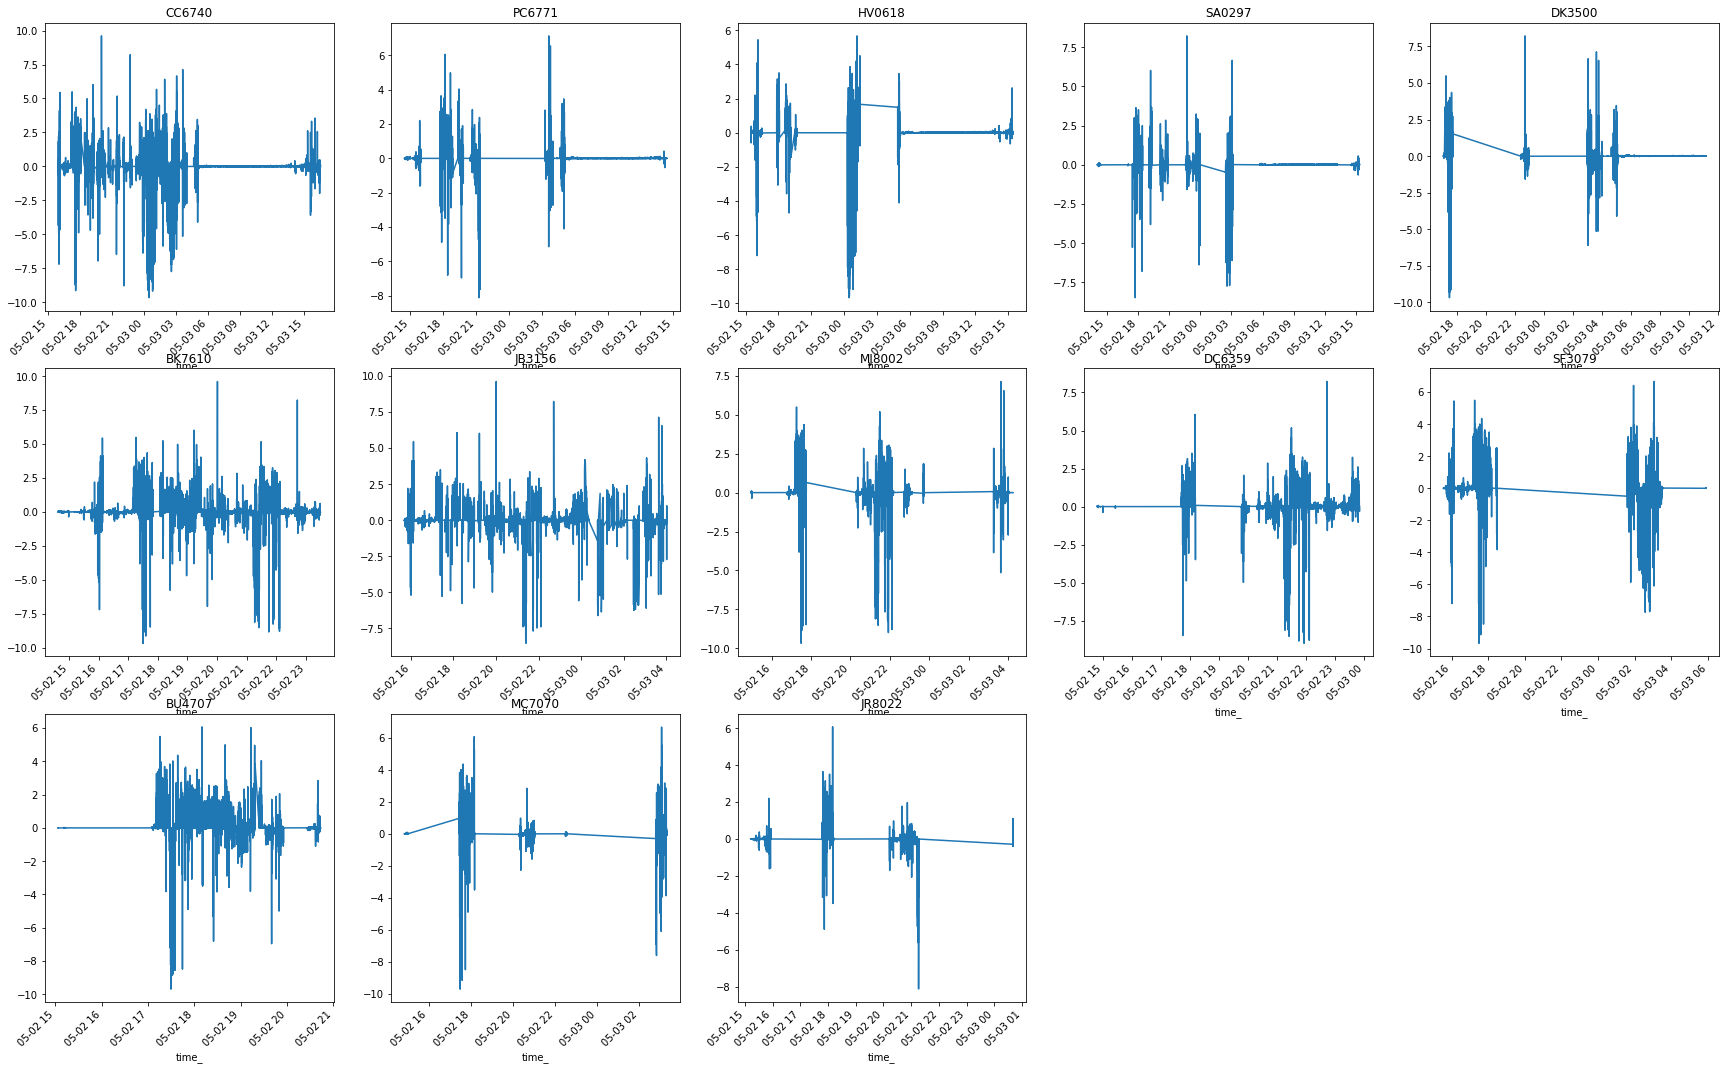

In [60]:
plot_ind_graphs(acc_unpack,y_col='x_median')

## looking at tacs

In [61]:
tacs.groupby('participant').TAC_Reading.describe()

,count,mean,std,min,25%,50%,75%,max
participant,,,,,,,,
BK7610,57.0,0.041313,0.050705,-0.002732,0.000744,0.012099,0.074544,0.171758
BU4707,57.0,0.041313,0.050705,-0.002732,0.000744,0.012099,0.074544,0.171758
CC6740,56.0,0.066026,0.077362,-0.003032,0.001334,0.034584,0.100917,0.244715
DC6359,55.0,0.043535,0.048602,-0.004337,0.002179,0.027723,0.077334,0.153367
DK3500,51.0,0.024415,0.033744,-0.003397,0.002358,0.012633,0.025280,0.127514
HV0618,54.0,0.039005,0.050129,-0.006374,0.004126,0.017031,0.060611,0.193617
JB3156,55.0,0.029400,0.031349,-0.001214,0.000487,0.017122,0.060906,0.096366
JR8022,47.0,0.067056,0.061737,-0.012196,0.013447,0.060656,0.103579,0.213314
MC7070,56.0,0.062988,0.069810,-0.012387,0.001625,0.025526,0.133964,0.196655


- Looking at the max value, can see that each participant did get intoxicated at some point
- Looking at min value- there are some natural variance around 0 - so baseline is not 0
    - would be useful to take into account the baseline variance to be consider the measurement error

In [62]:
tacs_timeidx = tacs.set_index('timestamp')

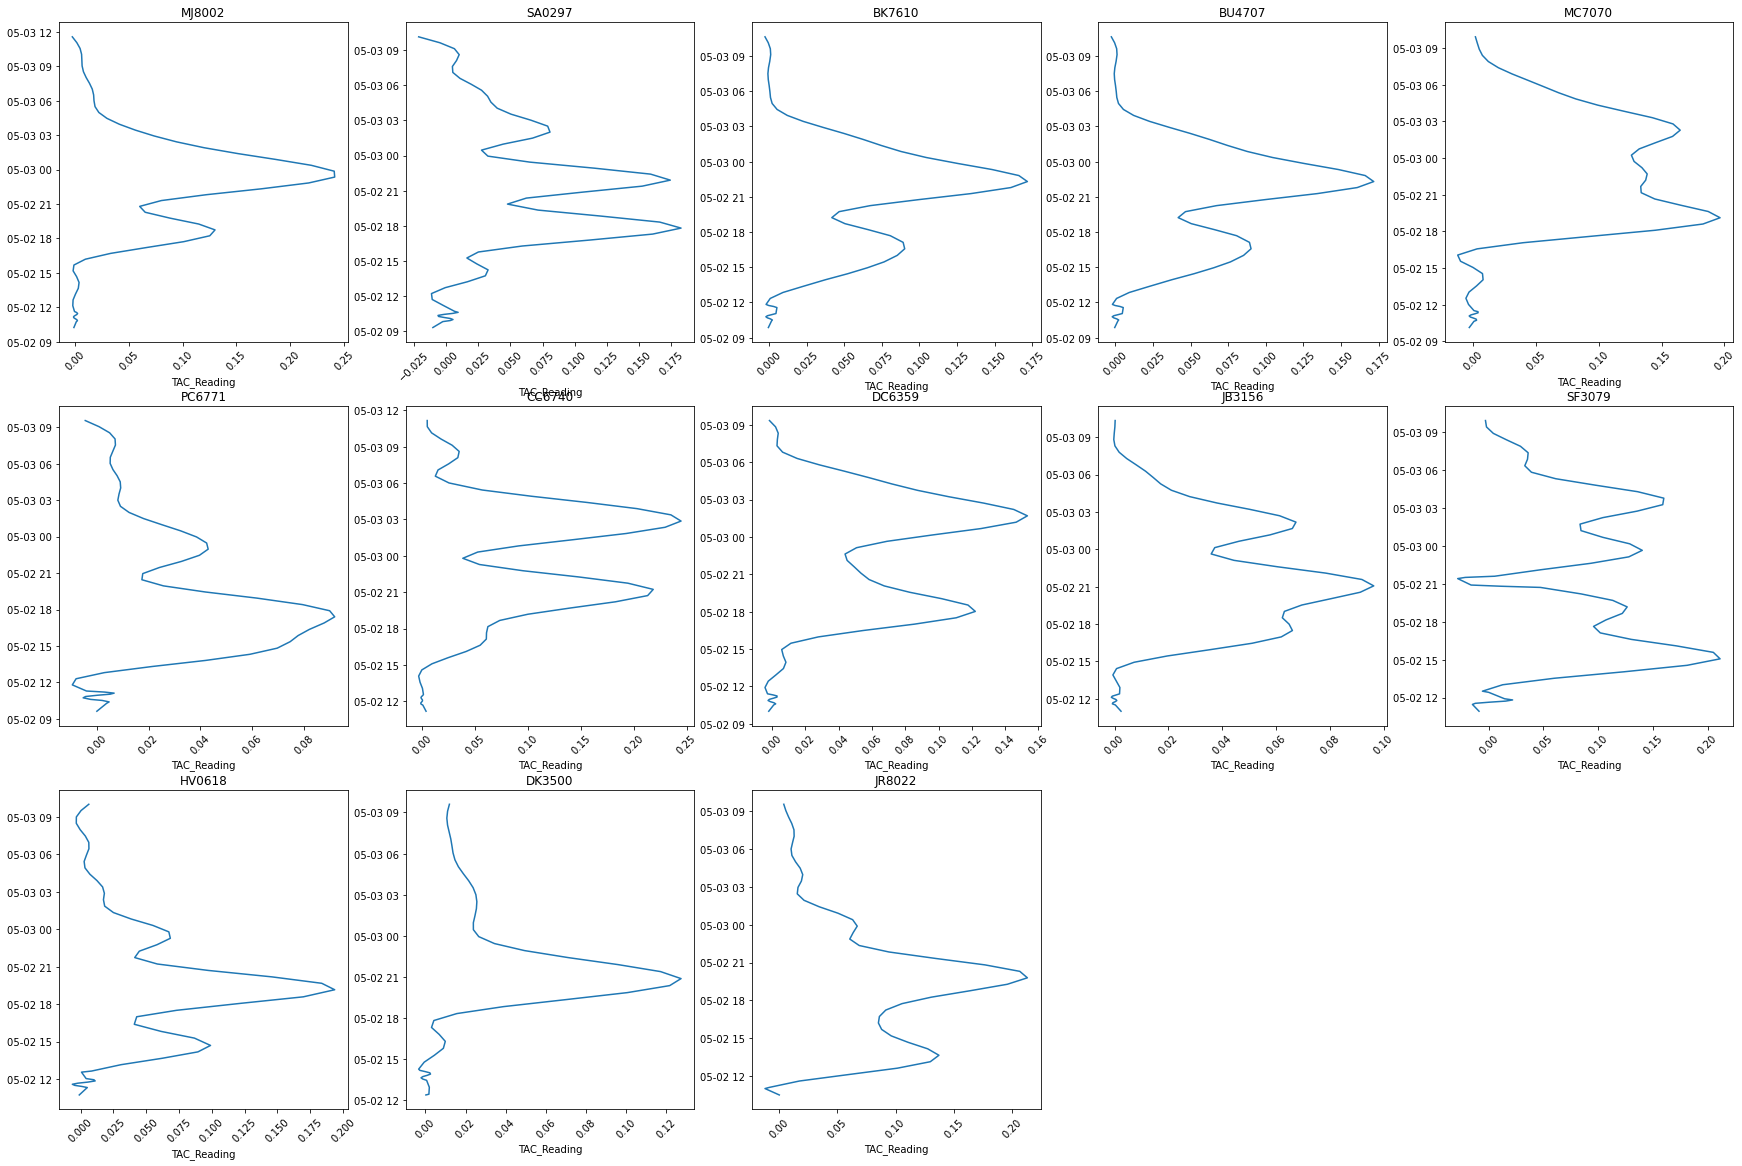

In [63]:
plot_ind_graphs(tacs,'timestamp','TAC_Reading','participant')

* plot the TAC_reading, and the x,y,z median reading every10s together

In [64]:
def plot_both_graphs(acc_df=acc_unpack,tac_df=tacs,scaling_factor=50,time_col='time_',y_col='x_median',pid_col='pid__x',tac_time_col='timestamp',tac_tac_col='TAC_Reading',tac_part_col='participant'):
    plt.figure(figsize=(30,20))
    n=0
    pid_index = acc_df[pid_col].value_counts().index # this would be a list of all the particiapnt codes
    size = len(pid_index)
    for val in pid_index:
        df1 = acc_df[acc_df[pid_col]==val]
        df2 = tac_df[tac_df[tac_part_col]==val]
        ax = plt.subplot(3,(size//3)+1,n+1)
        n+=1
        plt.plot(df1[time_col],df1[y_col]/scaling_factor)
        plt.plot(df2[tac_time_col],df2[tac_tac_col])
        plt.plot(df2[tac_time_col],np.ones(len(df2[tac_time_col]))*0.08) # the line for intoxication
        plt.xticks(rotation=45)
        plt.title(str(val))
    plt.show()

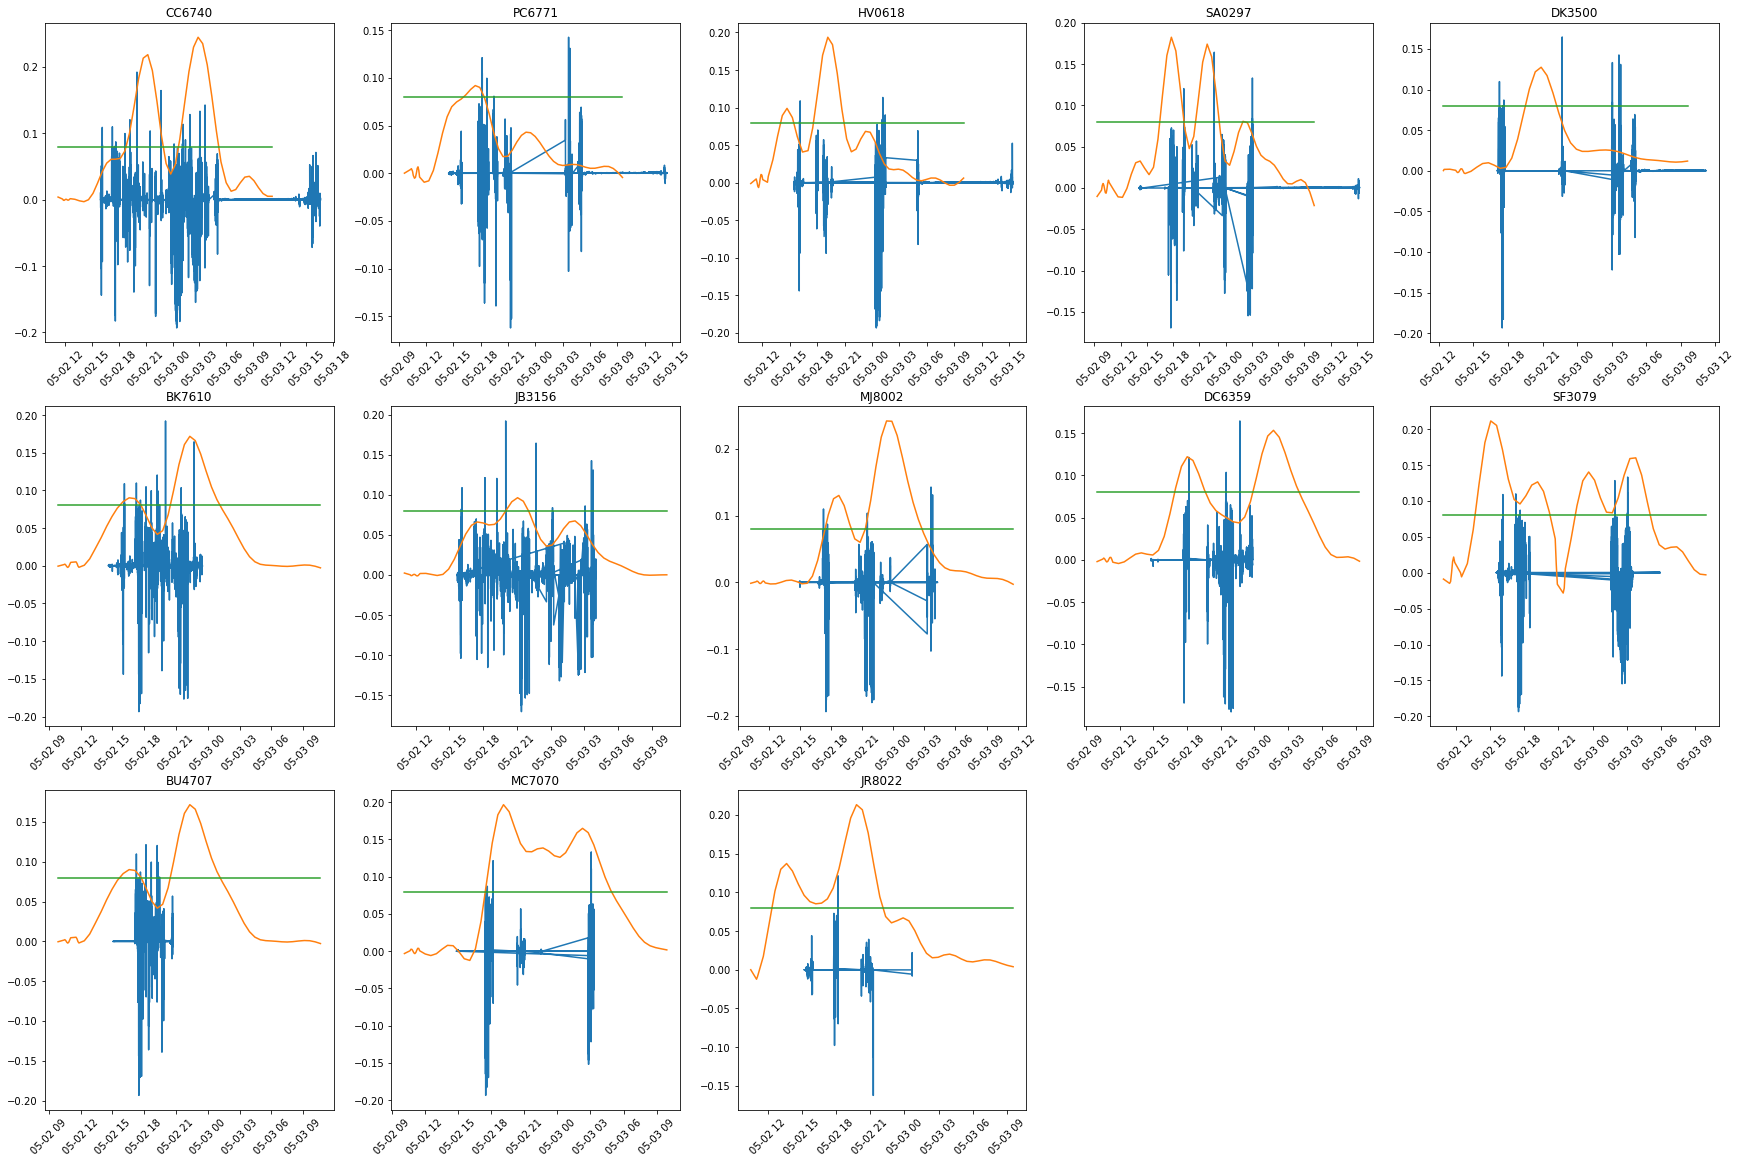

In [65]:
plot_both_graphs(acc_unpack,tacs)

* green line is 0.08 - the threshold for intoxication
* median is better at smoothing noise than mean

## Merging the two datasets

- If we want to combine the TACS table and the acc table, they have different time frame, TACS is every 30min, while acc is every 10 seconds - need to make certain assumption
    * let's say we have TAC data for 5, 5:30,6 then we assume 5-5:30 has the same value as 5, 5:30-6 has the value as 5:30

In [66]:
import datetime
# lets make a start time and and end time for the timestamp
tacs['start_time'] = tacs.timestamp
tacs['end_time'] = tacs.timestamp+ datetime.timedelta(seconds=60*30)

* having trouble with merging using python --- use SQL instead, ignore this block:

```python
# for each row of acc_renorm, want to get the value from TAC tables where the timeframe is correct

# for each participant, we want to get the TAC values

def merge_dataframe(acc_df=acc_renorm_10s,tac_df=tacs,pid_col='pid_',tac_part_col='participant'):
    pid_index = acc_df[pid_col].value_counts().index # this would be a list of all the particiapnt codes
    merge = pd.DataFrame()
    for pid in pid_index:
        acc_ind = acc_df[acc_df[pid_col]==pid]
        tac_ind = tac_df[tac_df[tac_part_col]==pid]
        
        tac_time = tac_ind.timestamp
        
        for idx in acc_ind.index:
            time_val = acc_ind.loc[idx,'time_']
            mask = (tac_time<=time_val) & ((tac_time+ datetime.timedelta(seconds=60*30))>=time_val)
            acc_ind.loc[idx,'TAC_reading'] = tac_ind[mask].TAC_Reading.values
        merge = pd.concat([merge,acc_ind])
    return merge
```

* Using SQL to merge the two dataframes instead

In [67]:
# using SQLite to merge the two dataframes because it is more time efficient and more straight-forward

import sqlite3

#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
acc_unpack.to_sql('acc', conn, index=False)
tacs.to_sql('tacs', conn, index=False)

query = '''
    select  
        *
    from
        acc join tacs on acc.pid__x=tacs.participant AND acc.time_ between tacs.start_time and tacs.end_time
    '''
# want to make sure the participant code match and that the time is in between the start and end time for the TAC reading
merge = pd.read_sql_query(query, conn)

In [68]:
acc_unpack.shape

(164477, 119)

In [69]:
tacs.shape

(715, 6)

In [70]:
merge.shape # looks like some data is dropped

(138131, 125)

In [71]:
merge[merge.x_var.isnull()==True].head()

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,x_mfcc_14,x_mfcc_15,x_mfcc_16,x_mfcc_17,x_mfcc_18,x_mfcc_19,x_mfcc_20,x_mfcc_21,x_mfcc_22,x_mfcc_23,x_mfcc_24,x_mfcc_25,x_mfcc_26,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,y_mfcc_14,y_mfcc_15,y_mfcc_16,y_mfcc_17,y_mfcc_18,y_mfcc_19,y_mfcc_20,y_mfcc_21,y_mfcc_22,y_mfcc_23,y_mfcc_24,y_mfcc_25,y_mfcc_26,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,z_mfcc_14,z_mfcc_15,z_mfcc_16,z_mfcc_17,z_mfcc_18,z_mfcc_19,z_mfcc_20,z_mfcc_21,z_mfcc_22,z_mfcc_23,z_mfcc_24,z_mfcc_25,z_mfcc_26,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,timestamp,TAC_Reading,participant,intoxicated,start_time,end_time


In [72]:
merge.isnull().sum()

pid__x                  0
time_                   0
x_zerocrossings         0
x_entropy               0
x_density               0
x_centroids             0
y_zerocrossings         0
y_entropy               0
y_density               0
y_centroids             0
z_zerocrossings         0
z_entropy               0
z_density               0
z_centroids             0
x_mfcc_1                0
x_mfcc_2                0
x_mfcc_3                0
x_mfcc_4                0
x_mfcc_5                0
x_mfcc_6                0
x_mfcc_7                0
x_mfcc_8                0
x_mfcc_9                0
x_mfcc_10               0
x_mfcc_11               0
x_mfcc_12               0
x_mfcc_13               0
x_mfcc_14          137333
x_mfcc_15          137333
x_mfcc_16          137333
x_mfcc_17          137333
x_mfcc_18          137333
x_mfcc_19          137333
x_mfcc_20          137333
x_mfcc_21          137333
x_mfcc_22          137333
x_mfcc_23          137333
x_mfcc_24          137333
x_mfcc_25   

In [73]:
merge.head()

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,x_mfcc_14,x_mfcc_15,x_mfcc_16,x_mfcc_17,x_mfcc_18,x_mfcc_19,x_mfcc_20,x_mfcc_21,x_mfcc_22,x_mfcc_23,x_mfcc_24,x_mfcc_25,x_mfcc_26,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,y_mfcc_14,y_mfcc_15,y_mfcc_16,y_mfcc_17,y_mfcc_18,y_mfcc_19,y_mfcc_20,y_mfcc_21,y_mfcc_22,y_mfcc_23,y_mfcc_24,y_mfcc_25,y_mfcc_26,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,z_mfcc_14,z_mfcc_15,z_mfcc_16,z_mfcc_17,z_mfcc_18,z_mfcc_19,z_mfcc_20,z_mfcc_21,z_mfcc_22,z_mfcc_23,z_mfcc_24,z_mfcc_25,z_mfcc_26,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,timestamp,TAC_Reading,participant,intoxicated,start_time,end_time
0,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.89461728523751,97.0,6.113909,0.000093,5.83526421298062,93.0,5.642486,0.000224,4.24253735085402,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027,0.001231,4.800705,-0.686815,0.3039,0.035103,0.2526,-0.1963,0.009442,0.00685,0.003249,2.994924,0.178858,0.4489,0.057704,2017-05-02 14:26:57,0.052238,BK7610,0,2017-05-02 14:26:57,2017-05-02 14:56:57
1,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.89461728523751,97.0,6.113909,0.000093,5.83526421298062,93.0,5.642486,0.000224,4.24253735085402,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6167,-0.5980,0.027371,0.02940,0.062144,-0.663048,-0.069078,1.2147,0.250475,0.5739,-0.5099,-0.005762,-0.0270,0.047209,-0.784699,0.146248,1.0838,0.217080,0.9157,-0.6540,0.013335,0.00115,0.060221,1.002979,0.499894,1.5697,0.245455,2017-05-02 14:26:57,0.052238,BK7610,0,2017-05-02 14:26:57,2017-05-02 14:56:57
2,PC6771,2017-05-02 14:37:50,61.0,3.132623,0.003668,4.91379225889868,51.0,3.115796,0.002053,4.87691650053811,64.0,4.379598,0.002559,4.28230461315063,105.772068,95.821360,7.477252,9.780437,-6.470749,1.168486,-16.530995,-9.985987,-3.267197,0.693273,-5.272045,-8.406678,-12.405929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.470008,92.954278,14.054759,-4.055372,-1.931226,-2.774032,-18.231735,-15.142524,-16.703471,2.327591,-20.813024,1.685566,-8.330577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.509562,104.709176,29.207176,3.299612,-21.526791,-2.638259,-23.999313,-20.069887,-15.563819,0.831841,-16.507206,-5.222619,-25.221675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027

In [74]:
# checking that the merge was done properly -- participant should match pid_
merge[merge.pid__x!=merge.participant]

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,x_mfcc_14,x_mfcc_15,x_mfcc_16,x_mfcc_17,x_mfcc_18,x_mfcc_19,x_mfcc_20,x_mfcc_21,x_mfcc_22,x_mfcc_23,x_mfcc_24,x_mfcc_25,x_mfcc_26,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,y_mfcc_14,y_mfcc_15,y_mfcc_16,y_mfcc_17,y_mfcc_18,y_mfcc_19,y_mfcc_20,y_mfcc_21,y_mfcc_22,y_mfcc_23,y_mfcc_24,y_mfcc_25,y_mfcc_26,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,z_mfcc_14,z_mfcc_15,z_mfcc_16,z_mfcc_17,z_mfcc_18,z_mfcc_19,z_mfcc_20,z_mfcc_21,z_mfcc_22,z_mfcc_23,z_mfcc_24,z_mfcc_25,z_mfcc_26,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,timestamp,TAC_Reading,participant,intoxicated,start_time,end_time


In [110]:
# checking that the time_ is between start_time and end_time
merge[(merge.time_>=merge.start_time)&(merge.time_<=merge.end_time)].shape

(138131, 125)

In [111]:
# having couple hundreds non-numerica (string) for centroids -> coerce into NaN then drop na
merge['x_centroids'] = pd.to_numeric(merge['x_centroids'],errors='coerce')
merge['y_centroids'] = pd.to_numeric(merge['y_centroids'],errors='coerce')
merge['z_centroids'] = pd.to_numeric(merge['z_centroids'],errors='coerce')

In [119]:
# don't need all columns, drop some columns
clean_merge = merge.drop(columns=['timestamp','participant','start_time','end_time'])

In [120]:
clean_merge = clean_merge.dropna(axis=1,thresh=(merge.shape[0]*0.7))
#['_mfcc_14','_mfcc_15','_mfcc_16','_mfcc_17','_mfcc_18','_mfcc_19','_mfcc_20','_mfcc_21','_mfcc_22','_mfcc_23','_mfcc_24','_mfcc_25','_mfcc_26']

In [130]:
clean_merge.shape

(137333, 82)

In [131]:
clean_merge = clean_merge.dropna(axis=0)

In [132]:
clean_merge.columns.values

array(['pid__x', 'time_', 'x_zerocrossings', 'x_entropy', 'x_density',
       'x_centroids', 'y_zerocrossings', 'y_entropy', 'y_density',
       'y_centroids', 'z_zerocrossings', 'z_entropy', 'z_density',
       'z_centroids', 'x_mfcc_1', 'x_mfcc_2', 'x_mfcc_3', 'x_mfcc_4',
       'x_mfcc_5', 'x_mfcc_6', 'x_mfcc_7', 'x_mfcc_8', 'x_mfcc_9',
       'x_mfcc_10', 'x_mfcc_11', 'x_mfcc_12', 'x_mfcc_13', 'y_mfcc_1',
       'y_mfcc_2', 'y_mfcc_3', 'y_mfcc_4', 'y_mfcc_5', 'y_mfcc_6',
       'y_mfcc_7', 'y_mfcc_8', 'y_mfcc_9', 'y_mfcc_10', 'y_mfcc_11',
       'y_mfcc_12', 'y_mfcc_13', 'z_mfcc_1', 'z_mfcc_2', 'z_mfcc_3',
       'z_mfcc_4', 'z_mfcc_5', 'z_mfcc_6', 'z_mfcc_7', 'z_mfcc_8',
       'z_mfcc_9', 'z_mfcc_10', 'z_mfcc_11', 'z_mfcc_12', 'z_mfcc_13',
       'x_max', 'x_min', 'x_mean', 'x_median', 'x_var', 'x_kurtosis',
       'x_skewness', 'x_interval', 'x_rms', 'y_max', 'y_min', 'y_mean',
       'y_median', 'y_var', 'y_kurtosis', 'y_skewness', 'y_interval',
       'y_rms', 'z_max', 'z_min'

In [133]:
clean_merge.shape

(137333, 82)

In [134]:
clean_merge.head()

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,TAC_Reading,intoxicated
0,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.894617,97.0,6.113909,0.000093,5.835264,93.0,5.642486,0.000224,4.242537,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027,0.001231,4.800705,-0.686815,0.3039,0.035103,0.2526,-0.1963,0.009442,0.00685,0.003249,2.994924,0.178858,0.4489,0.057704,0.052238,0
1,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.894617,97.0,6.113909,0.000093,5.835264,93.0,5.642486,0.000224,4.242537,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,0.6167,-0.5980,0.027371,0.02940,0.062144,-0.663048,-0.069078,1.2147,0.250475,0.5739,-0.5099,-0.005762,-0.0270,0.047209,-0.784699,0.146248,1.0838,0.217080,0.9157,-0.6540,0.013335,0.00115,0.060221,1.002979,0.499894,1.5697,0.245455,0.052238,0
2,PC6771,2017-05-02 14:37:50,61.0,3.132623,0.003668,4.913792,51.0,3.115796,0.002053,4.876917,64.0,4.379598,0.002559,4.282305,105.772068,95.821360,7.477252,9.780437,-6.470749,1.168486,-16.530995,-9.985987,-3.267197,0.693273,-5.272045,-8.406678,-12.405929,63.470008,92.954278,14.054759,-4.055372,-1.931226,-2.774032,-18.231735,-15.142524,-16.703471,2.327591,-20.813024,1.685566,-8.330577,90.509562,104.709176,29.207176,3.299612,-21.526791,-2.638259,-23.999313,-20.069887,-15.563819,0.831841,-16.507206,-5.222619,-25.221675,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027,0.001231,4.800705,-0.686815,0.3039,0.035103,0.2526,-0.1963,0.009442,0.00685,0.003249,2.994924,0.178858,0.4489,0.057704,0.059162,0
3,PC6771,2017-05-02 14:37:50,61.0,3.132623,0.003668,4.913792,51.0,3.115796,0.002053,4.876917,64.0,4.379598,0.002559,4.282305,105.772068,95.821360,7.477252,9.780437,-6.470749,1.168486,-16.530995,-9.985987,-3.267197,0.693273,-5.272045,-8.406678,-12.405929,63.470008,92.954278,14.054759,-4.055372,-1.931226,-2.774032,-18.231735,-15.142524,-16.703471,2.327591,-20.813024,1.685566,-8.330577,90.509562,104.709176,29.207176,3.299612,-21.526791,-2.638259,-23.999313,-20.069887,-15.563819,0.831841,-16.507206,-5.222619,-25.221675,0.6167,-0.5980,0.027371,0.02940,0.062144,-0.663048,-0.069078,1.2147,0.250475,0.5739,-0.5099,-0.005762,-0.0270,0.047209,-0.784699,0.146248,1.0838,0.217080,0.9157,-0.6540,0.013335,0.00115,0.060221,1.002979,0.499894,1.5697,0.245455,0.059162,0
4,BK7610,2017-05-02 14:38:00,90.0,6.042793,0.000028,5.069854,97.0,5.988535,0.000057,4.987723,105.0,6.137170,0.000094,5.656369,-128.150593,75.908207,24.421039,21.191641,-11.630954,1.303259,2.993964,-3.135440,-3.1249

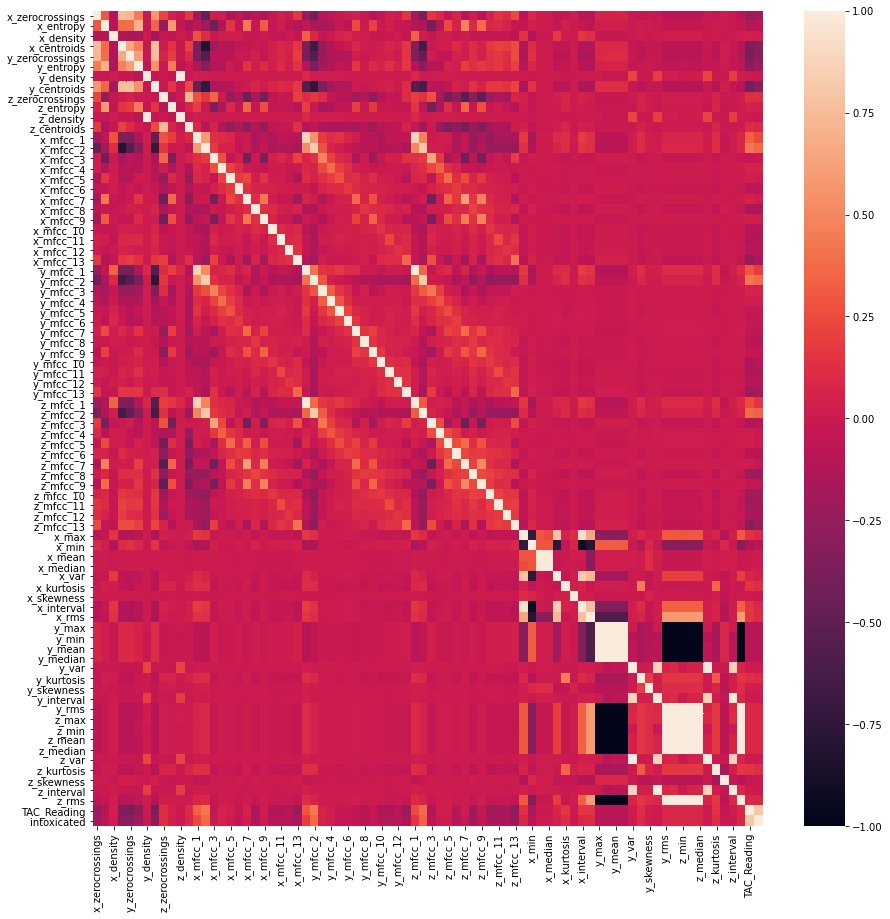

In [135]:
plt.figure(figsize=(15,15))
sns.heatmap(clean_merge.corr())

* correlation matrix of all the columns with each other
* some features are very correlated with each other (for example mean and median, and the mfaa)
* need to be careful of multi-colinearity

In [136]:
clean_merge.head()

,pid__x,time_,x_zerocrossings,x_entropy,x_density,x_centroids,y_zerocrossings,y_entropy,y_density,y_centroids,z_zerocrossings,z_entropy,z_density,z_centroids,x_mfcc_1,x_mfcc_2,x_mfcc_3,x_mfcc_4,x_mfcc_5,x_mfcc_6,x_mfcc_7,x_mfcc_8,x_mfcc_9,x_mfcc_10,x_mfcc_11,x_mfcc_12,x_mfcc_13,y_mfcc_1,y_mfcc_2,y_mfcc_3,y_mfcc_4,y_mfcc_5,y_mfcc_6,y_mfcc_7,y_mfcc_8,y_mfcc_9,y_mfcc_10,y_mfcc_11,y_mfcc_12,y_mfcc_13,z_mfcc_1,z_mfcc_2,z_mfcc_3,z_mfcc_4,z_mfcc_5,z_mfcc_6,z_mfcc_7,z_mfcc_8,z_mfcc_9,z_mfcc_10,z_mfcc_11,z_mfcc_12,z_mfcc_13,x_max,x_min,x_mean,x_median,x_var,x_kurtosis,x_skewness,x_interval,x_rms,y_max,y_min,y_mean,y_median,y_var,y_kurtosis,y_skewness,y_interval,y_rms,z_max,z_min,z_mean,z_median,z_var,z_kurtosis,z_skewness,z_interval,z_rms,TAC_Reading,intoxicated
0,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.894617,97.0,6.113909,0.000093,5.835264,93.0,5.642486,0.000224,4.242537,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027,0.001231,4.800705,-0.686815,0.3039,0.035103,0.2526,-0.1963,0.009442,0.00685,0.003249,2.994924,0.178858,0.4489,0.057704,0.052238,0
1,BK7610,2017-05-02 14:37:50,75.0,4.855201,0.000069,2.894617,97.0,6.113909,0.000093,5.835264,93.0,5.642486,0.000224,4.242537,-126.839835,75.811645,33.731758,37.922820,24.574722,15.584666,-5.488032,19.770648,0.103161,-12.341042,11.325623,20.351206,-14.951593,-65.398634,71.496213,-1.072275,17.460540,21.268464,2.719850,7.998887,-5.852924,-2.138627,3.474911,-2.183444,-5.210576,-10.132319,-49.776802,113.037707,8.886712,6.447194,19.919287,-2.241747,3.518623,6.139536,-3.448233,-0.906160,14.582660,0.471432,-2.639936,0.6167,-0.5980,0.027371,0.02940,0.062144,-0.663048,-0.069078,1.2147,0.250475,0.5739,-0.5099,-0.005762,-0.0270,0.047209,-0.784699,0.146248,1.0838,0.217080,0.9157,-0.6540,0.013335,0.00115,0.060221,1.002979,0.499894,1.5697,0.245455,0.052238,0
2,PC6771,2017-05-02 14:37:50,61.0,3.132623,0.003668,4.913792,51.0,3.115796,0.002053,4.876917,64.0,4.379598,0.002559,4.282305,105.772068,95.821360,7.477252,9.780437,-6.470749,1.168486,-16.530995,-9.985987,-3.267197,0.693273,-5.272045,-8.406678,-12.405929,63.470008,92.954278,14.054759,-4.055372,-1.931226,-2.774032,-18.231735,-15.142524,-16.703471,2.327591,-20.813024,1.685566,-8.330577,90.509562,104.709176,29.207176,3.299612,-21.526791,-2.638259,-23.999313,-20.069887,-15.563819,0.831841,-16.507206,-5.222619,-25.221675,0.1443,-0.1092,0.011724,0.00300,0.001411,1.688599,0.938724,0.2535,0.039300,0.1151,-0.1888,0.002166,0.0027,0.001231,4.800705,-0.686815,0.3039,0.035103,0.2526,-0.1963,0.009442,0.00685,0.003249,2.994924,0.178858,0.4489,0.057704,0.059162,0
3,PC6771,2017-05-02 14:37:50,61.0,3.132623,0.003668,4.913792,51.0,3.115796,0.002053,4.876917,64.0,4.379598,0.002559,4.282305,105.772068,95.821360,7.477252,9.780437,-6.470749,1.168486,-16.530995,-9.985987,-3.267197,0.693273,-5.272045,-8.406678,-12.405929,63.470008,92.954278,14.054759,-4.055372,-1.931226,-2.774032,-18.231735,-15.142524,-16.703471,2.327591,-20.813024,1.685566,-8.330577,90.509562,104.709176,29.207176,3.299612,-21.526791,-2.638259,-23.999313,-20.069887,-15.563819,0.831841,-16.507206,-5.222619,-25.221675,0.6167,-0.5980,0.027371,0.02940,0.062144,-0.663048,-0.069078,1.2147,0.250475,0.5739,-0.5099,-0.005762,-0.0270,0.047209,-0.784699,0.146248,1.0838,0.217080,0.9157,-0.6540,0.013335,0.00115,0.060221,1.002979,0.499894,1.5697,0.245455,0.059162,0
4,BK7610,2017-05-02 14:38:00,90.0,6.042793,0.000028,5.069854,97.0,5.988535,0.000057,4.987723,105.0,6.137170,0.000094,5.656369,-128.150593,75.908207,24.421039,21.191641,-11.630954,1.303259,2.993964,-3.135440,-3.1249

In [137]:
clean_merge.to_csv('./data/merged_df.csv',index=False)

* continue onto the next notebook: Bar_Crawl_finaldataEDA_modelTraining